In [1]:
import tensorflow as tf
import os
import numpy as np
import requests
from io import BytesIO
import statistics
import random
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,BatchNormalization
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model


In [2]:
main_path = '/Users/shahriyar/Desktop/programming/Python/Optriment/data/'
train = os.path.join(main_path,'train')
test = os.path.join(main_path,'test')

In [3]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
,
    validation_split=0.2,
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
)

In [4]:
train_data = train_generator.flow_from_directory(class_mode='categorical',
    directory=train,
    batch_size=32,
    shuffle=True,
    seed=42,
    target_size=(224, 224),
    subset='training',
  )
val_data = train_generator.flow_from_directory(class_mode='categorical',
    batch_size=32,
    directory=train,
    target_size=(224, 224),
    shuffle=True,
    seed=42,
    subset='validation'
  )

# Create test data generator

test_data = test_generator.flow_from_directory(
    directory=test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2400 images belonging to 200 classes.
Found 600 images belonging to 200 classes.
Found 3033 images belonging to 200 classes.


In [5]:
data_augment = tf.keras.Sequential([


  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2024-07-26 09:44:33.950900: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-26 09:44:33.951097: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
pretrained_model = tf.keras.applications.ResNet101(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False

# # Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(pretrained_model.layers))

# Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in pretrained_model.layers[:fine_tune_at]:
#   layer.trainable = False

171446536/171446536 [==============================] - 101s 1us/step
Number of layers in the base model:  346


In [7]:
checkpoint_path = "birds_classification_model_checkpoint2"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 10,
                               restore_best_weights = True) 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

In [8]:
inputs = pretrained_model.input
x = data_augment(inputs)
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)
outputs = Dense(200, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    validation_data=val_data,
    validation_steps=len(val_data),
    epochs=200,
    callbacks=[
        early_stopping,
        reduce_lr,
        checkpoint_callback,

    ]
)

Epoch 1/200


2024-07-26 09:46:52.569949: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-26 09:46:55.384848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - ETA: 0s - loss: 7.9407 - accuracy: 0.0050

2024-07-26 09:47:07.614245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 21s 227ms/step - loss: 7.9407 - accuracy: 0.0050 - val_loss: 5.3297 - val_accuracy: 0.0000e+00
Epoch 2/200
75/75 [==============================] - 14s 183ms/step - loss: 5.3455 - accuracy: 0.0054 - val_loss: 5.3129 - val_accuracy: 0.0000e+00
Epoch 3/200
75/75 [==============================] - 13s 168ms/step - loss: 5.3095 - accuracy: 0.0067 - val_loss: 5.3073 - val_accuracy: 0.0050
Epoch 4/200
75/75 [==============================] - 14s 187ms/step - loss: 5.2950 - accuracy: 0.0079 - val_loss: 5.3041 - val_accuracy: 0.0067
Epoch 5/200
75/75 [==============================] - 14s 187ms/step - loss: 5.2763 - accuracy: 0.0054 - val_loss: 5.2905 - val_accuracy: 0.0083
Epoch 6/200
75/75 [==============================] - 13s 176ms/step - loss: 5.2647 - accuracy: 0.0083 - val_loss: 5.2849 - val_accuracy: 0.0067
Epoch 7/200
75/75 [==============================] - 13s 175ms/step - loss: 5.2549 - accuracy: 0.0121 - val_loss: 5.2843 - val_accuracy: 0.0

In [9]:
initial_test_loss, initial_test_acc = model.evaluate(test_data)
print(f"Initial Test accuracy: {initial_test_acc}")

95/95 [==============================] - 17s 175ms/step - loss: 3.3210 - accuracy: 0.3459
Initial Test accuracy: 0.34586217999458313


In [10]:
model.save('best_resnet101_model_1.h5')

In [11]:
def plot_loss_curves(history):
    
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

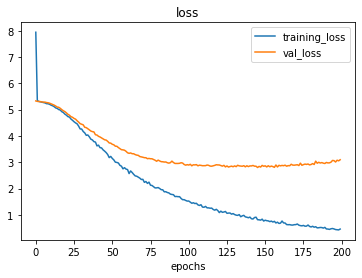

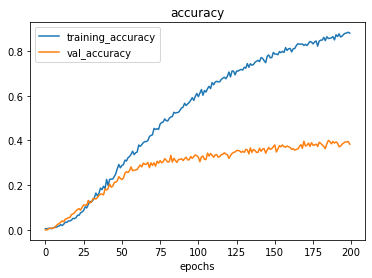

In [12]:
plot_loss_curves(history)

In [13]:
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
len(labels)

200

In [14]:
def predict_pipeline(image_path):
    # Define the input image size
    input_shape = (224, 224)
            
    # load image data
    img = load_img(image_path, target_size=input_shape)
            
    # convert image to array
    x = img_to_array(img)
            
    # preprocess the image using efficientnet preprocessor
    x = preprocess_input(x)

    # Make the prediction
    preds = model.predict(np.array([x]))

    # get the index of the predicted class
    index = np.argmax(preds)
    
    # get the predicted class name
    predicted_class = labels[index]

    # Return prediced_class
    return predicted_class

1/1 [==============================] - 0s 33ms/step


<Figure size 432x288 with 0 Axes>

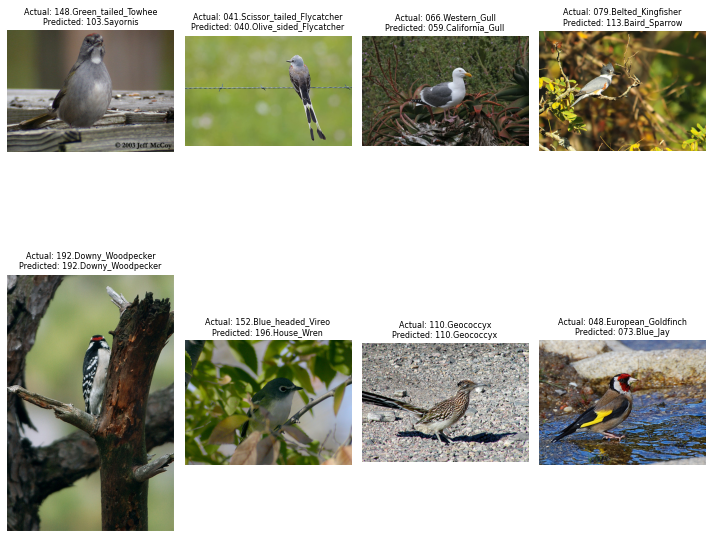

In [16]:
n_rows = 2
n_cols = 4
# Here we are using gcf to clen the plot if the cell is being runned 2 or more times
fig = plt.gcf()

# Create a figure and subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)

# set size of each image
fig.set_size_inches(10, 10)

species = []
img_path = {}

# choosing a image at random
for i in range(n_rows*n_cols):
    species.append(random.choice(os.listdir(test)))

for bird in species:
    img_choice = random.choice(os.listdir(os.path.join(train,bird)))
    full_path = os.path.join(train,bird,img_choice)
    img_path[bird] = full_path

# reading and printing the image
i = 0
for key in img_path.keys():
    sp = plt.subplot(n_rows, n_cols, i + 1)
    img = mimg.imread(img_path[key])
    predicted = predict_pipeline(img_path[key])
    sp.set_title('Actual: '+str(key)+'\n'+'Predicted: '+str(predicted), fontsize=8)
    sp.axis('off')
    plt.imshow(img)
    i += 1

plt.tight_layout()

In [ ]:
def predict_pipeline_url(image_url):
    # get the image from the url
    response = requests.get(image_url)

    # Define the input image size
    input_shape = (300, 300)
            
    # load image data
    img = load_img(BytesIO(response.content), target_size=input_shape)
            
    # convert image to array
    x = img_to_array(img)
            
    # preprocess the image using efficientnet preprocessor
    x = preprocess_input(x)

    # Make the prediction
    preds = model.predict(np.array([x]))

    # get the index of the predicted class
    index = np.argmax(preds)
 
    # get the predicted class name
    predicted_class = labels[index]
    
    return predicted_class

In [ ]:
def predict_bird_from_URL(image_url):
    # Here we are using gcf to clean the plot if the cell is being runned 2 or more times
    fig = plt.gcf()
    fig.set_size_inches(5, 5)
    
    # get and store the response from URL
    response = requests.get(image_url)
    
    # read the image
    img = mimg.imread(BytesIO(response.content), format='jpg')
    
    # predict the image from URL
    predicted = predict_pipeline_url(image_url)
    
    # pint the image along with predicted label
    plt.title('Predicted: '+str(predicted), fontsize=10)
    plt.axis('off')
    plt.imshow(img)

In [ ]:
predict_bird_from_URL('https://cdn.download.ams.birds.cornell.edu/api/v1/asset/78541101/1200')

In [ ]:
predict_bird_from_URL('https://cdn.britannica.com/22/137322-050-EC0B557E/Gyrfalcon.jpg')